# Installing

In [1]:
!pip install numpy pandas requests inflection seaborn scipy matplotlib IPython scikit-learn statsmodels pmdarima tqdm statsforecast


[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install inflection seaborn statsforecast pmdarima tqdm


[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


# 0.0. Imports

In [3]:
import math
import numpy  as np
import pandas as pd
import random
import requests
import warnings
import inflection
import seaborn as sns

from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error,r2_score
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.tree          import DecisionTreeRegressor
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima
from tqdm import tqdm

warnings.filterwarnings( 'ignore' )

## 0.0.1  Help functions

In [4]:
# Função utilizada para calcular o erro dos modelos 

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )


## 0.1. Loading data

In [5]:
# Carregando os dados do IBOV
df = pd.read_csv('dados/data_ibov_2.csv')

# 1.0 Data Description

In [6]:
df1 = df.copy()

In [7]:
df1.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,28.12.2023,134.185,134.194,134.389,133.832,"7,81M","-0,01%"
1,27.12.2023,134.194,133.523,134.195,133.328,"6,17M","0,49%"
2,26.12.2023,133.533,132.753,133.645,132.753,"5,15M","0,59%"
3,22.12.2023,132.753,132.182,133.035,132.094,"8,23M","0,43%"
4,21.12.2023,132.182,130.826,132.277,130.822,"8,68M","1,05%"


## 1.2. Data Dimensions

In [8]:
# Verificar as linhas e colunas do df
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 2476
Number of Cols: 7


## 1.3. Data Types

In [9]:
df1.dtypes

Data         object
Último      float64
Abertura    float64
Máxima      float64
Mínima      float64
Vol.         object
Var%         object
dtype: object

In [10]:
df1.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,28.12.2023,134.185,134.194,134.389,133.832,"7,81M","-0,01%"
1,27.12.2023,134.194,133.523,134.195,133.328,"6,17M","0,49%"
2,26.12.2023,133.533,132.753,133.645,132.753,"5,15M","0,59%"
3,22.12.2023,132.753,132.182,133.035,132.094,"8,23M","0,43%"
4,21.12.2023,132.182,130.826,132.277,130.822,"8,68M","1,05%"


In [11]:
# Ajustar os dados do df IBOV ( retirar os caracteres de texto das colunas Vol e Var)

df1['Vol.'] = df1['Vol.'].str.replace('M','').str.replace(',','.').str.replace('K','').astype(float)
df1['Var%'] = df1['Var%'].str.replace('%','').str.replace(',','.').astype(float)

df1['Data'] = pd.to_datetime(df1['Data'])


## 1.4. Check NA

In [12]:
# Checar os valores nulos
df1.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

## 1.7. Descriptive Statistics

In [13]:
# Dados Estatístico da base
df1.describe().T

,count,mean,min,25%,50%,75%,max,std
Data,2476,2019-01-02 06:22:40.904684800,2014-01-02 00:00:00,2016-07-04 18:00:00,2019-01-07 12:00:00,2021-07-06 06:00:00,2023-12-28 00:00:00,NaN
Último,2476.0,84.596605,37.497,57.624,85.79,108.809,134.194,26.455365
Abertura,2476.0,84.564613,37.501,57.6025,85.768,108.791,134.194,26.445219
Máxima,2476.0,85.37855,38.031,58.0885,86.631,109.88475,134.389,26.614901
Mínima,2476.0,83.777387,37.046,57.0815,85.052,107.8825,133.832,26.271315
Vol.,2475.0,8.312444,1.19,3.53,4.88,10.215,980.07,34.137766
Var%,2476.0,0.051143,-14.78,-0.7825,0.055,0.9225,13.91,1.573083


### 1.7.1. Numerical Atributes

### Neste gráfico de distribuição observamos que não temos uma distribuição simétrica, a maior parte dos dados estão concentrados entre  45mil á 60mil pontos e depois entre 100mil e 115mil 

<Axes: xlabel='Último'>

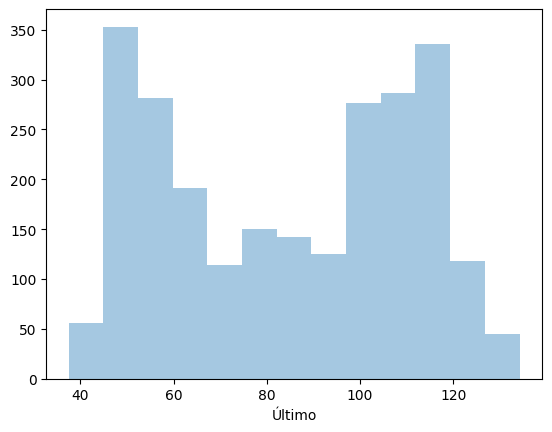

In [14]:

sns.distplot( df1['Último'], kde=False )

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [15]:
df2 = df1.copy()

## 2.1. Feature Engineering

### Nesta etapa, acrescentamos mais colunas para representar o dia,mês e ano separadamente para facilitar análises mais especifica como sasonalizade por mês e semana e também para ajudar no desempenho do modelo

In [16]:
df2.set_index('Data', inplace=True)

#year
df2['year'] = df2.index.year

# month
df2['month'] =  df2.index.month


# day
df2['day'] = df2.index.day

# day of week
df2['day_of_week'] = df2.index.day_of_week

df2.dtypes

Último         float64
Abertura       float64
Máxima         float64
Mínima         float64
Vol.           float64
Var%           float64
year             int32
month            int32
day              int32
day_of_week      int32
dtype: object

In [17]:
df2 = df2.sort_index()
df2 = df2.loc['2020-01-01':]

In [18]:
df2.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,year,month,day,day_of_week
Data,,,,,,,,,,
2020-01-02,118.573,115.652,118.573,115.649,5.16,2.53,2020,1,2,3
2020-01-03,117.707,118.564,118.792,117.341,6.83,-0.73,2020,1,3,4
2020-01-06,116.878,117.707,117.707,116.269,6.57,-0.70,2020,1,6,0
2020-01-07,116.662,116.872,117.076,115.965,4.85,-0.18,2020,1,7,1
2020-01-08,116.247,116.667,117.335,115.693,5.91,-0.36,2020,1,8,2


## 2.2. Criacao das Hipoteses

**1.** O Desempenho do mercado varia de acordo com o dia da semana ?

**2.** O Mercado apresenta padrões de sazonalidade nos meses ?

**3.** O Desempenho do Mercado é influenciado pelo Volume Financeiro do dia ?

**4.** Qual a tendência do mercado no último ano ?

**5.** O mercado costuma fechar com pontos mais altos no último trimestre ?


# 3.0.  Exploration Data Analisys -  EDA

In [19]:
df3 = df2.copy()

In [20]:
df3['day_of_week'].unique()

array([3, 4, 0, 1, 2], dtype=int32)

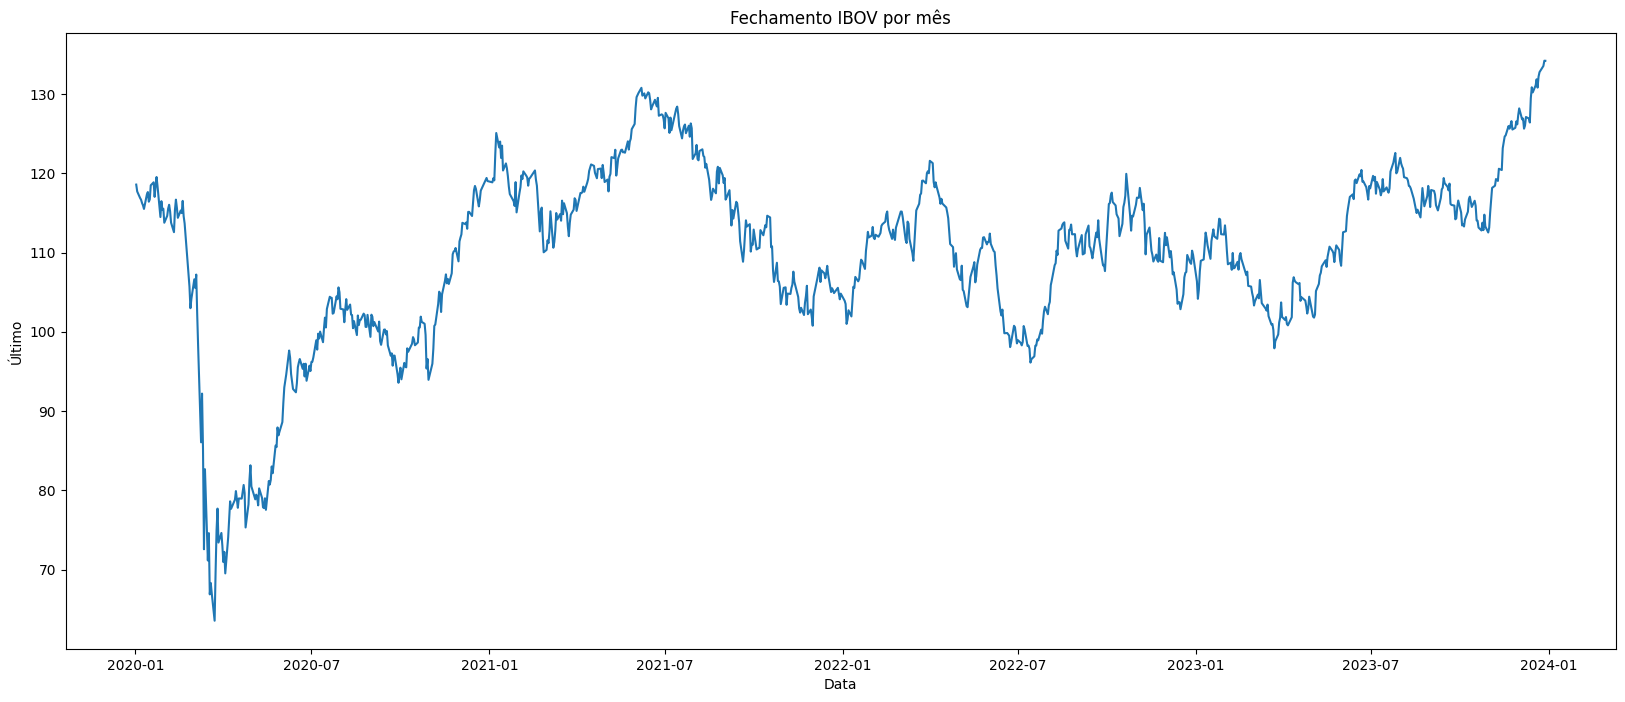

In [21]:
# Exibindo a distribuição do fechamento ao longo do período.
plt.figure(figsize=(20,8))
sns.lineplot(x=df3.index,y='Último',data= df3)
plt.title('Fechamento IBOV por mês')
plt.show()

### Na correlação abaixo, identificamos features que não poderão ser utilizadas no modelo ( Abertura,fechamento, maxima e mínima), pois são informações futuras que são geradas a partir do fechamento do dia. E também observamos que a correlação mais forte com a variável alvo é a coluna "ano" , como já observado tem uma correlação positiva a medida do período analisado.

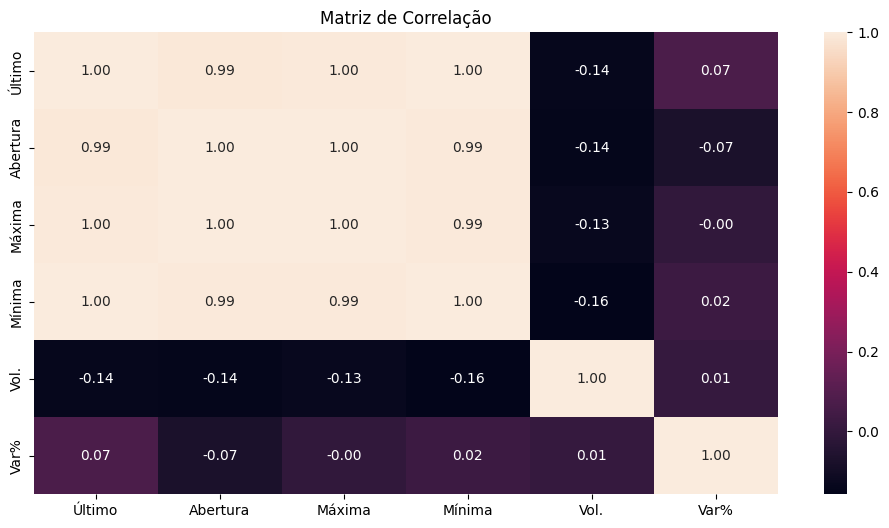

In [22]:
# Verificando a correlação entre as variáveis numéricas

plt.figure(figsize=(12,6))
num_attributes = df3.select_dtypes( include=['int64', 'float64'] )

correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True, fmt='.2f' )
plt.title('Matriz de Correlação')
plt.show()

### 3.1 H1. O Desempenho do mercado varia de acordo com o dia da semana ?
R: Sim, conforme gráficos abaixo, observamos que o mercado habitualmente fecha com o pontos mais altos as terças e sextas.

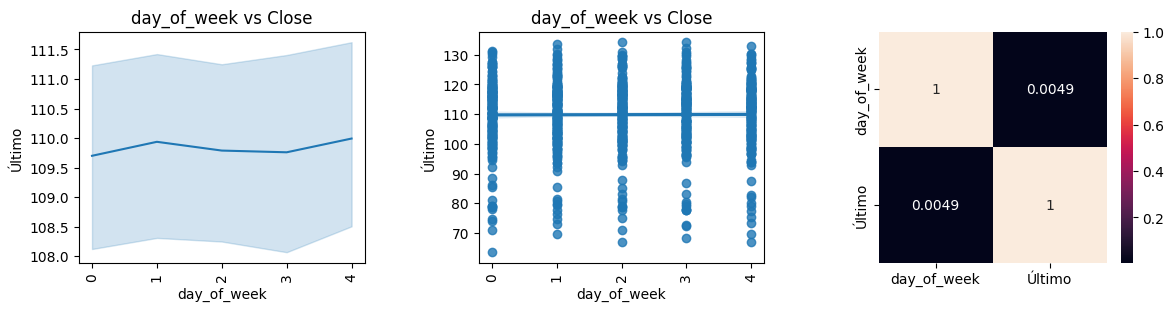

In [23]:
aux1 = df3[['day_of_week','Último']]


fig, axes = plt.subplots(1, 3, figsize=(14, 3))
plt.subplots_adjust(wspace=0.4)
#fig.delaxes(axes[1, 0])

# Plot on the first subplot (axes[0, 0])
sns.lineplot(x='day_of_week', y='Último', data=df3, ax=axes[0])
axes[0].set_title('day_of_week vs Close')
axes[0].tick_params(axis='x', rotation=90)

sns.regplot(x='day_of_week', y='Último', data=df3, ax=axes[1])
axes[1].set_title('day_of_week vs Close')
axes[1].tick_params(axis='x', rotation=90)

sns.heatmap( aux1.corr( method='pearson' ), annot=True )


plt.show()

### 3.2 H2. O Mercado apresenta padrões de sazonalidade nos meses ?
R: Sim, observamos uma correlação positiva nos meses, sendo que o ultimos meses do ano do período analisado fecham com pontos mais altos comparados aos primeiros meses do ano.

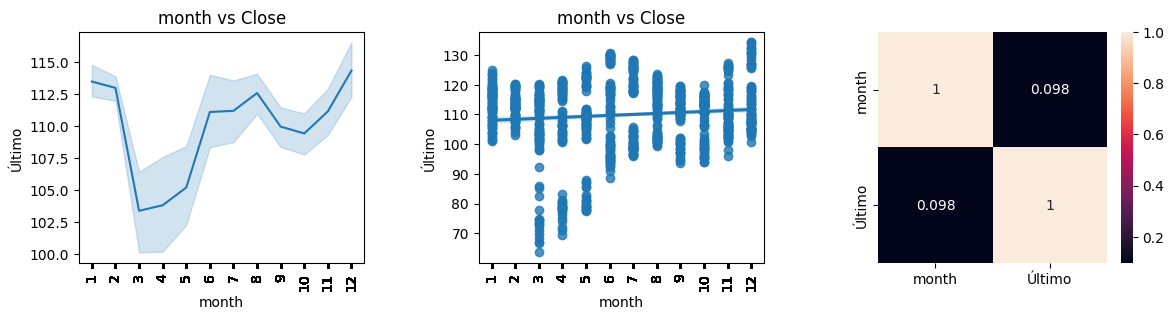

In [24]:
aux2 = df3[['month','Último']]

fig, axes = plt.subplots(1, 3, figsize=(14, 3))
plt.subplots_adjust(wspace=0.4)
#fig.delaxes(axes[1, 0])

# Plot on the first subplot (axes[0, 0])
sns.lineplot(x='month', y='Último', data=aux2, ax=axes[0])
axes[0].set_title('month vs Close')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xticks(aux2['month'])

sns.regplot(x='month', y='Último', data=aux2, ax=axes[1])
axes[1].set_title('month vs Close')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(aux2['month'])

sns.heatmap( aux2.corr( method='pearson' ), annot=True )


plt.show()

### 3.3 H3. O Desempenho do Mercado é influenciado pelo volume do dia ?
R: Sim, há uma correlação negativa, quanto mais volume de dinheiro é negociado no dia, o mercado tem uma leve tendência a fechar menor comparado aos dias com baixo volume

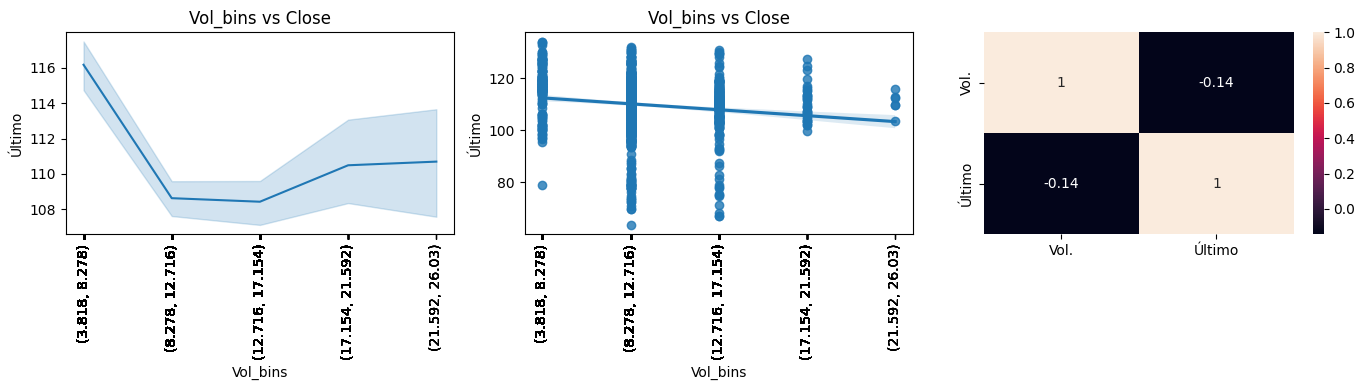

In [25]:
aux3 = df3[['Vol.','Último']]

aux3['Vol_bins'] = pd.cut(aux3['Vol.'], bins=5)
aux3['Vol_bins_cat'] = aux3['Vol_bins']
aux3['Vol_bins_cat'] = aux3['Vol_bins_cat'].astype(str).str.replace(']',')')
aux3['Vol_bins'] = aux3['Vol_bins'].cat.codes.astype(float)


# Configurar o tamanho do gráfico
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plt.subplots_adjust(wspace=0.6)

# Plotar um gráfico de linha com rótulos personalizados no primeiro subplot
sns.lineplot(x='Vol_bins', y='Último', data=aux3, ax=axes[0])
axes[0].set_title('Vol_bins vs Close')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xticks(aux3['Vol_bins'])
axes[0].set_xticklabels(aux3['Vol_bins_cat'])

# Plotar um gráfico de regressão com rótulos personalizados no segundo subplot
sns.regplot(x='Vol_bins', y='Último', data=aux3, ax=axes[1])
axes[1].set_title('Vol_bins vs Close')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(aux3['Vol_bins'])
axes[1].set_xticklabels(aux3['Vol_bins_cat'])


aux33 = df3[['Vol.','Último']]
sns.heatmap( aux33.corr( method='pearson' ), annot=True )

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()


### 3.4 H4. Qual a tendência do mercado no último ano ?

R: Observamos uma tendência de alta nos últimos 12 meses de 2023

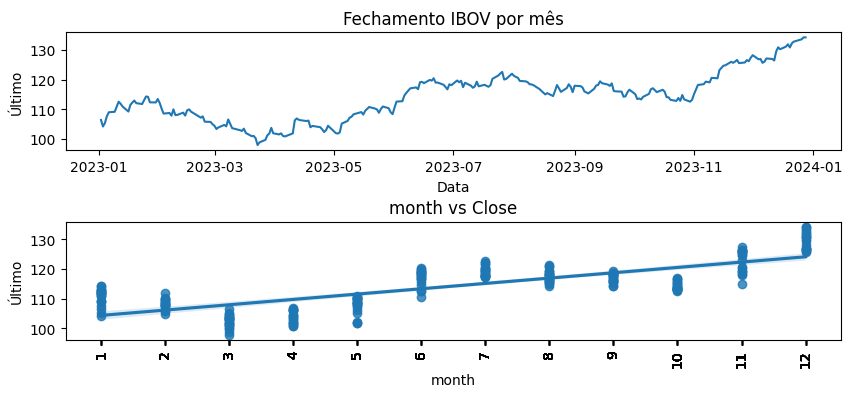

<Figure size 1500x400 with 0 Axes>

In [26]:
df3 = df3.sort_index()

aux4 = df3.loc['2023-01-01':'2023-12-31']

fig, axes = plt.subplots(2, 1, figsize=(10, 4))
plt.subplots_adjust(hspace=0.6)

plt.figure(figsize=(15,4))
sns.lineplot(x=aux4.index,y='Último',data= aux4, ax=axes[0])
axes[0].set_title('Fechamento IBOV por mês')

sns.regplot(x='month', y='Último', data=aux4, ax=axes[1])
axes[1].set_title('month vs Close')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(aux4['month'])


plt.show()

#### 4.0. PASSO 04 - DATA PREPARATION

In [27]:
df4 = df3.copy()

In [28]:
df4.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,year,month,day,day_of_week
Data,,,,,,,,,,
2020-01-02,118.573,115.652,118.573,115.649,5.16,2.53,2020,1,2,3
2020-01-03,117.707,118.564,118.792,117.341,6.83,-0.73,2020,1,3,4
2020-01-06,116.878,117.707,117.707,116.269,6.57,-0.70,2020,1,6,0
2020-01-07,116.662,116.872,117.076,115.965,4.85,-0.18,2020,1,7,1
2020-01-08,116.247,116.667,117.335,115.693,5.91,-0.36,2020,1,8,2


## 5.1. Rescaling

In [29]:
df5 = df4.copy()

### Nesta etapa fizemos uma transformação nas colunas temporais de forma a reduzir a escala no range de 0 á 1. Essa transformação foi realizada com o intuito de melhorar a perfomance dos modelos.

### 5.3.3. Nature Transformation

In [30]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )



features = df5[['day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]

# Adicione essas características ao seu conjunto de dados original
df5 = pd.concat([df5, features], axis=1)

# Agora você podae usar df5 em seu modelo de machine learning


# 6.0. PASSO 06 - FEATURE SELECTION

In [31]:
df6 = df5.copy()
df6.columns

Index(['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%', 'year',
       'month', 'day', 'day_of_week', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos'],
      dtype='object')

## 6.1. Separando os dados em treino e teste

In [32]:
df6 = df6['Último'].reset_index()
#df6.set_index('Data', inplace=True)

df6.rename(columns={'Último': 'y','Data': 'ds'}, inplace=True)

In [33]:
# training dataset
X_train = df6[df6['ds'] < '2023-06-01']
y_train = X_train['y']

# test dataset
X_test = df6[df6['ds'] > '2023-05-31']
y_test = X_test['y']

h = X_test['ds'].nunique()
print( 'Training Min Date: {}'.format( X_train['ds'].min() ) )
print( 'Training Max Date: {}'.format( X_train['ds'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['ds'].min() ) )
print( 'Test Max Date: {}'.format( X_test['ds'].max() ) )

Training Min Date: 2020-01-02 00:00:00
Training Max Date: 2023-05-31 00:00:00

Test Min Date: 2023-06-01 00:00:00
Test Max Date: 2023-12-28 00:00:00


# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

## 7.1. Arima Model

Para o período que utilizamos , o resultado ADF nos mostrou que o p_value é 3,9% rejeitando a hipótese nula. Por esse motivo seguimos com ao treinamento e predição do modelo sem transformar a escala dos dados.

In [34]:
# teste ADF ( estacionaridade)
# Se o P Value <= 0.05 (5%) , então rejeitamos a hipótese Nula, com nível de confiança de 95%

# H0 - Hipótese Nula ( Série não é estacionária)
# H1 - Hipótese Alternativa ( Série é estacionária)
X = df5['Último'].values
result = adfuller(X)

# Resultado : Hipótese Nula Rejeitada - Apesar do teste estatístico ser maior do que os valores críticos, 
# o P-Value é de 3%, refeijando a hipótese Nula.

print('Teste ADF ')
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores Críticos :")

for key,value in result[4].items():
    print(f"\t {key}: {value}")


Teste ADF 
Teste Estatístico: -2.3255684784312365
P-Value: 0.16385416841498823
Valores Críticos :
	 1%: -3.4370062675076807
	 5%: -2.8644787205542492
	 10%: -2.568334722615888


In [35]:
# Exemplo de diferenciação de primeira ordem
#X_train_diff = X_train['y'].diff().dropna()
#X_test_diff = X_test['y'].diff().dropna()

In [36]:
from pmdarima import auto_arima

# Série temporal: series
auto_model = auto_arima(X_train['y'], suppress_warnings=True)
auto_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  849
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1689.385
Date:                Wed, 24 Jan 2024   AIC                           3384.769
Time:                        20:46:24   BIC                           3398.998
Sample:                             0   HQIC                          3390.220
                                - 849                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1297      0.016     -8.283      0.000      -0.160      -0.099
ma.L2          0.0930      0.016      5.749      0.000       0.061       0.125
sigma2         3.1471      0.068     46.471      0.000       3.014       3.280
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2686.69
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
# ARIMA MODEL

#p, d, q = 1, 0, 1
p, d, q = 6, 0, 6


arima_model = ARIMA(X_train['y'], order=(p, d, q))
arima_fit = arima_model.fit()

# FIT AND PREDICT
h = h
forecast = arima_fit.get_forecast(steps=h)
forecast_values = forecast.predicted_mean

# Convertendo em DF para Merge
df_arima = pd.DataFrame(forecast_values)
X_test_a = pd.DataFrame(X_test)

# Resetando os índices

df_arima = df_arima.reset_index(drop=True).reset_index()
X_test_a = X_test_a.reset_index(drop=True).reset_index()

In [38]:
df_arima['predicted_mean'] = df_arima['predicted_mean'].round(3)
result_a = X_test_a.merge(df_arima,on='index',how='left')
result_a.head(5)

,index,ds,y,predicted_mean
0,0,2023-06-01,110.565,108.246
1,1,2023-06-02,112.558,108.126
2,2,2023-06-05,112.696,108.418
3,3,2023-06-06,114.610,108.691
4,4,2023-06-07,115.488,108.476


In [39]:
# performance
arima_result = ml_error( 'Arima Model', y_test, forecast_values )
arima_result

,Model Name,MAE,MAPE,RMSE
0,Arima Model,10.512973,0.086233,11.816449


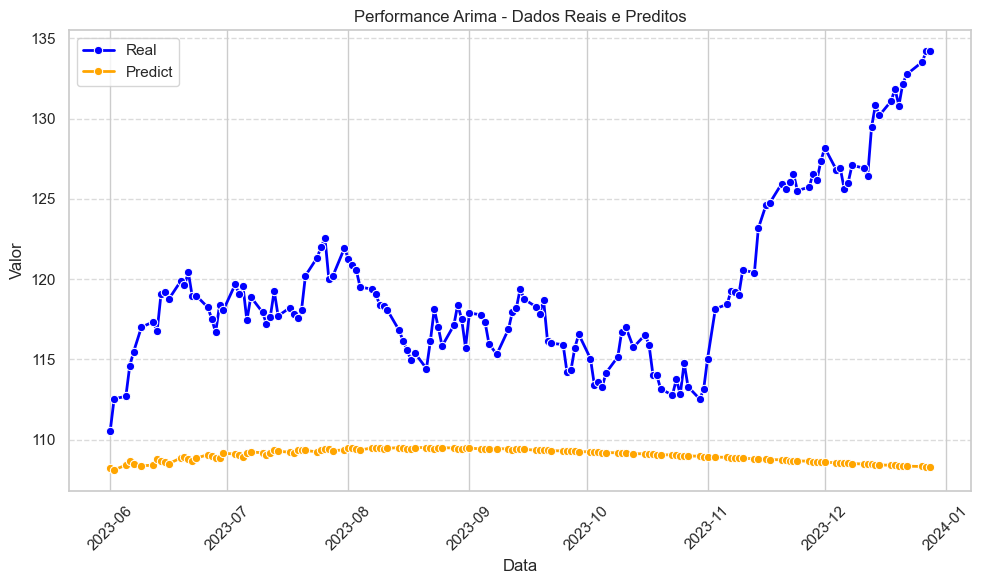

In [40]:
# Configuração do estilo do seaborn
sns.set(style='whitegrid', palette='Set2')

# Criar o gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(x='ds', y='y', data=result_a, label='Real', marker='o', color='blue', linewidth=2)
sns.lineplot(x='ds', y='predicted_mean', data=result_a, label='Predict', marker='o', color='orange', linewidth=2)

# Adicionar intervalo de confiança se disponível (substitua 'ic_lower' e 'ic_upper' com seus nomes reais)
# sns.fill_between(x=result_a['ds'], y1=result_a['ic_lower'], y2=result_a['ic_upper'], color='gray', alpha=0.2, label='Confidence Interval')

# Adicionar rótulos e legendas
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Performance Arima - Dados Reais e Preditos')
plt.legend()

# Rotacionar as datas para melhorar a legibilidade
plt.xticks(rotation=45)

# Adicionar grade
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

## 7.2. Linear Regression Model

In [41]:
colunas_para_remover = ['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%', 'year', 'month', 'day']
df5 = df5.drop(columns=colunas_para_remover)


In [42]:
# training dataset
X_train_lr = df5.loc[ '2020-01-01': '2023-05-31'].drop(columns='Último')
y_train_lr = df5['Último'].loc['2020-01-01': '2023-05-31']

# test dataset
X_test_lr = df5.loc[ '2023-06-01':'2023-12-31'].drop(columns='Último')
y_test_lr = df5['Último'].loc['2023-06-01' : '2023-12-31']

print( 'Training Min Date: {}'.format( X_train_lr.index.min() ) )
print( 'Training Max Date: {}'.format( X_train_lr.index.max() ) )

print( '\nTest Min Date: {}'.format( X_test_lr.index.min() ) )
print( 'Test Max Date: {}'.format( X_test_lr.index.max() ) )

Training Min Date: 2020-01-02 00:00:00
Training Max Date: 2023-05-31 00:00:00

Test Min Date: 2023-06-01 00:00:00
Test Max Date: 2023-12-28 00:00:00


In [43]:


# 1° modelo de regressão linear
modelo = LinearRegression()

# Treine o modelo no conjunto de treinamento
modelo.fit(X_train_lr, y_train_lr)

# Faça previsões no conjunto de teste
y_pred = modelo.predict(X_test_lr)

# performance
lr_result = ml_error( 'Linear Regression', y_test, y_pred )
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,10.766471,0.088585,11.845456


In [44]:
df_lr = pd.DataFrame(y_pred).reset_index()
result_lr = X_test_a.merge(df_lr,on='index',how='left')
result_lr.rename(columns={0: 'lr_predict'}, inplace=True)

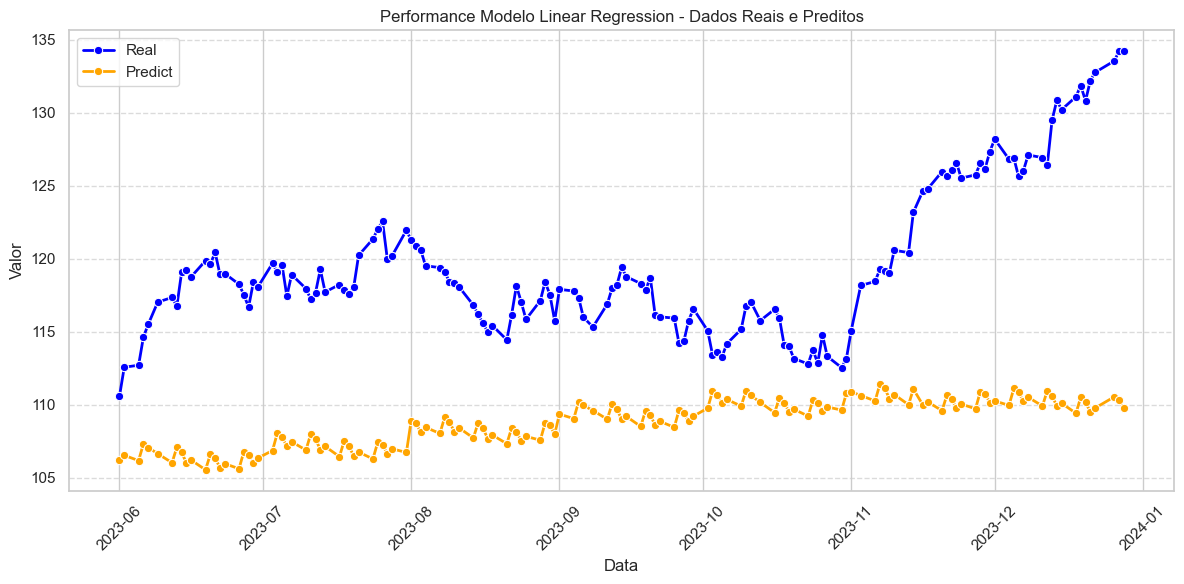

In [45]:
# Criar o gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(x='ds', y='y', data=result_lr, label='Real', marker='o', color='blue', linewidth=2)
sns.lineplot(x='ds', y='lr_predict', data=result_lr, label='Predict', marker='o', color='orange', linewidth=2)

# Adicionar intervalo de confiança se disponível (substitua 'ic_lower' e 'ic_upper' com seus nomes reais)
# sns.fill_between(x=result_a['ds'], y1=result_a['ic_lower'], y2=result_a['ic_upper'], color='gray', alpha=0.2, label='Confidence Interval')

# Adicionar rótulos e legendas
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Performance Modelo Linear Regression - Dados Reais e Preditos')
plt.legend()

# Rotacionar as datas para melhorar a legibilidade
plt.xticks(rotation=45)

# Adicionar grade
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

## 7.3. Decision Tree Model

In [46]:
# Criar o modelo de Decision Tree
tree_model = DecisionTreeRegressor(random_state=42)

# Treinar o modelo no conjunto de treino
tree_model.fit(X_train_lr, y_train_lr)

# Fazer previsões no conjunto de teste
y_pred_lr = tree_model.predict(X_test_lr)

In [47]:
# performance
dt_result = ml_error( 'Decision Tree', y_test, y_pred_lr )
dt_result

,Model Name,MAE,MAPE,RMSE
0,Decision Tree,12.100317,0.099914,14.357879


In [48]:
df_dt = pd.DataFrame(y_pred_lr).reset_index()
result_dt = X_test_a.merge(df_dt,on='index',how='left')
result_dt.rename(columns={0: 'dt_predict'}, inplace=True)

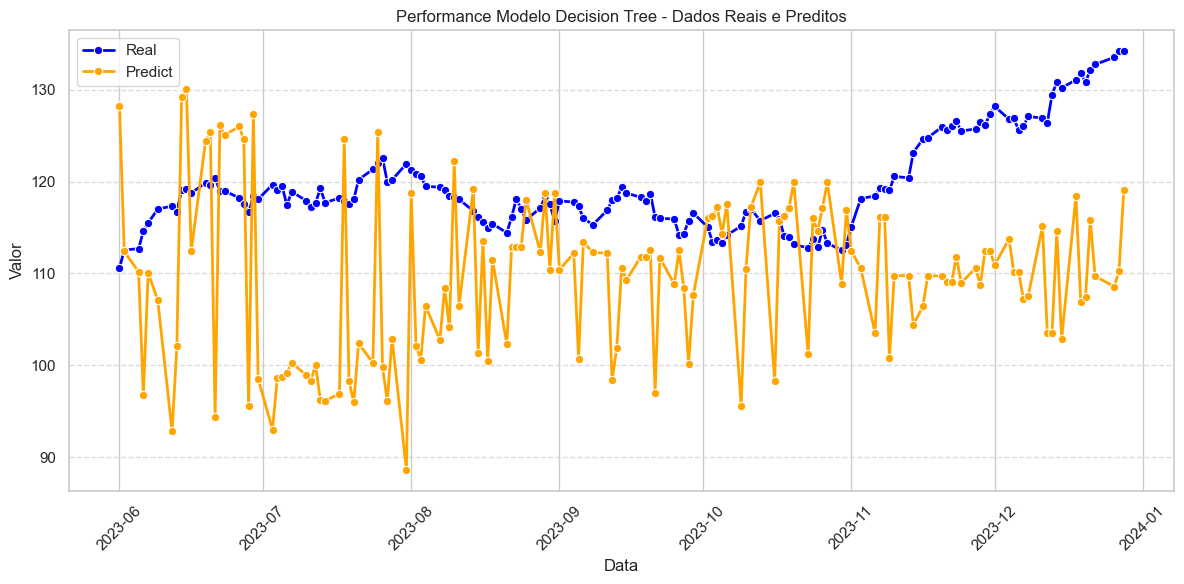

In [49]:
# Criar o gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(x='ds', y='y', data=result_dt, label='Real', marker='o', color='blue', linewidth=2)
sns.lineplot(x='ds', y='dt_predict', data=result_dt, label='Predict', marker='o', color='orange', linewidth=2)

# Adicionar intervalo de confiança se disponível (substitua 'ic_lower' e 'ic_upper' com seus nomes reais)
# sns.fill_between(x=result_a['ds'], y1=result_a['ic_lower'], y2=result_a['ic_upper'], color='gray', alpha=0.2, label='Confidence Interval')

# Adicionar rótulos e legendas
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Performance Modelo Decision Tree - Dados Reais e Preditos')
plt.legend()

# Rotacionar as datas para melhorar a legibilidade
plt.xticks(rotation=45)

# Adicionar grade
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

## 7.4. Random Forest Regressor

In [50]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( X_train_lr, y_train_lr )

# prediction
yhat_rf = rf.predict( X_test_lr )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test_lr ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,4.102810e+56,1.06384,2.417287e+57


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [51]:
modelling_result = pd.concat( [lr_result, arima_result, dt_result, ] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Arima Model,10.512973,0.086233,11.816449
0,Linear Regression,10.766471,0.088585,11.845456
0,Decision Tree,12.100317,0.099914,14.357879


## 9.0 Machine Learning Performance

In [52]:
df8 = result_lr.merge(result_a, on='index',how='left')
df9 = df8.merge(result_dt, on='index',how='left')

In [53]:
df9 = df9.drop(columns={'ds_y','y_y','ds','y'})
df9.rename(columns={'ds_x':'ds','y_x':'y_real','predicted_mean':'arima_predict'},inplace=True)

In [54]:
df9['error_arima'] = df9['y_real'] - df9['arima_predict']
df9['error_lr'] = df9['y_real'] - df9['lr_predict']
df9['error_dt'] = df9['y_real'] - df9['dt_predict']
df9.sample(10)

,index,ds,y_real,lr_predict,arima_predict,dt_predict,error_arima,error_lr,error_dt
26,26,2023-07-10,117.942,106.885202,109.184,98.937,8.758,11.056798,19.005
2,2,2023-06-05,112.696,106.165240,108.418,110.186,4.278,6.530760,2.510
138,138,2023-12-19,131.851,110.501238,108.400,106.864,23.451,21.349762,24.987
55,55,2023-08-18,115.409,107.908200,109.511,111.496,5.898,7.500800,3.913
36,36,2023-07-24,121.342,106.279771,109.242,100.270,12.100,15.062229,21.072
132,132,2023-12-11,126.916,109.903985,108.490,115.128,18.426,17.012015,11.788
134,134,2023-12-13,129.465,110.615805,108.464,103.540,21.001,18.849195,25.925
77,77,2023-09-20,118.695,109.270306,109.369,112.517,9.326,9.424694,6.178
33,33,2023-07-19,117.552,107.157488,109.372,98.245,8.180,10.394512,19.307
34,34,2023-07-20,118.083,106.449994,109.373,95.983,8.710,11.633006,22.100


<Axes: xlabel='ds', ylabel='y'>

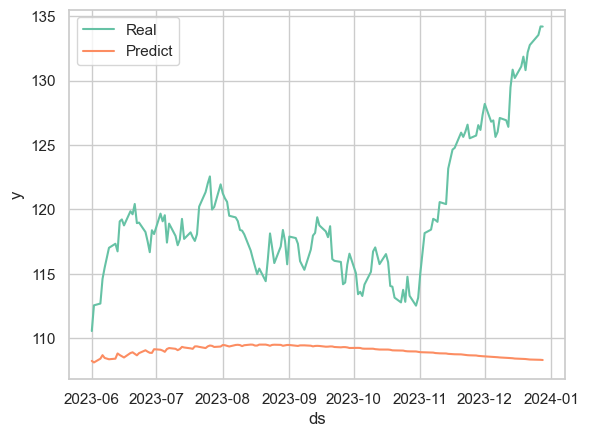

In [55]:

sns.lineplot( x='ds', y='y', data=result_a, label='Real' )
sns.lineplot( x='ds', y='predicted_mean', data=result_a, label='Predict' )



# 10.0 Final Conclusion 

Período Utilizado :

Utilizamos os dados a partir de 2020, pois considerando a recomendação de 80/20 e 90/10, esse range de dados temporal seria suficiente para treinar o modelo para o período que definimos prever ( 6 uúltimos meses de 2023) e também é um período com poucos ruídos externos como a crise em 2008 e pandemia em 2019.


Escolha das métricas de Avaliação do erro :

Optamos por utilziar o MAE (Erro Absoluto Médio), MAPE (Erro Percentual Absoluto Médio) e RMSE (Erro Quadrático Médio da Raiz) como métricas de avaliação do erro, por ser mais apropriado para modelos de regressão e previsão de valores do que utilizar a acurácia. Pois as métricas de erro fornecem uma medida mais sensível às diferenças absolutas entre as previsões e os valores reais,enquanto a acurácia, é comumente mais utilizada para avaliação de modelos de classificação, pois é uma avaliação binária.

Modelo Vencedor : ARIMA MODEL

Conforme dados comparativos na tabela da sessão 9.0 o modelo com a menor erro ( MAE,MAPE e RMSE) foi o Arima, testamos diversos cenários para definir os parâmentros P,D,Q que performaram em um resultado de 4.68 % de erro médio percentual (MAPE). Melhor resultado comparado aos outros modelos testados ( Linear Regression e Decision Tree ).


---

# 11.0 - Aplicando RNN LSTM (Long Short-Term Memory) 

In [56]:
!pip install keras pandas tensorflow


[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


# 11.1 - Loading Data and EDA

In [57]:
import pandas as pd

data = pd.read_csv("dados/Dados Históricos - Ibovespa 2014-2024.csv", sep=",")

ibovespa_merged = pd.concat([data])

# Convert 'Data' to datetime and check for missing values
ibovespa_merged['Data'] = pd.to_datetime(ibovespa_merged['Data'], format='%d.%m.%Y')

# Converting 'Vol.' to numeric (removing 'M' and 'K' and converting to millions and thousands respectively)
ibovespa_merged['Vol.'] = ibovespa_merged['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').str.replace(',', '').astype(float)

# Converting 'Var%' to numeric (removing '%' and converting to float)
ibovespa_merged['Var%'] = ibovespa_merged['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

# Settar indice em Data e dar sort
ibovespa_merged.set_index('Data', inplace=True)
ibovespa_merged.sort_index(inplace=True)

ibovespa_merged.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2024-01-09,131.447,132.424,132.426,131.203,929000000.0,-0.74
2024-01-10,130.841,131.447,131.628,130.438,896000000.0,-0.46
2024-01-11,130.649,130.841,131.308,129.898,976000000.0,-0.15
2024-01-12,130.265,130.652,131.927,130.265,39093000.0,-0.29
2024-01-15,131.521,130.265,131.553,130.253,575000000.0,0.96


In [58]:
# Filter data between two dates
# Irei filtrar dados de 6 anos para ter ideia de como se comportará o LSTM
ibovespa_filtered = ibovespa_merged.query("Data >= '2017-01-01'")

ibovespa_filtered.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2017-01-02,59.589,60.227,60.227,59.371,83373000.0,-1.06
2017-01-03,61.814,59.631,61.815,59.631,343000000.0,3.73
2017-01-04,61.589,61.811,61.940,61.302,293000000.0,-0.36
2017-01-05,62.071,61.594,62.409,61.594,342000000.0,0.78
2017-01-06,61.665,62.072,62.072,61.396,245000000.0,-0.65


In [59]:
train_data, test_data = ibovespa_filtered[0:int(len(ibovespa_filtered)*0.9)], ibovespa_filtered[int(len(ibovespa_filtered)*0.9):]
train_data

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2017-01-02,59.589,60.227,60.227,59.371,8.337300e+07,-1.06
2017-01-03,61.814,59.631,61.815,59.631,3.430000e+08,3.73
2017-01-04,61.589,61.811,61.940,61.302,2.930000e+08,-0.36
2017-01-05,62.071,61.594,62.409,61.594,3.420000e+08,0.78
2017-01-06,61.665,62.072,62.072,61.396,2.450000e+08,-0.65
...,...,...,...,...,...,...
2023-04-26,102.312,103.220,103.668,102.233,1.012000e+09,-0.88
2023-04-27,102.923,102.310,103.177,101.975,1.130000e+09,0.60
2023-04-28,104.432,102.923,104.432,102.449,1.309000e+09,1.47


In [60]:
train = train_data.iloc[:, 0:1].values # selecting closing prices
len(train)

1568

In [61]:
# Importando bibliotecas necessárias
from sklearn.preprocessing import MinMaxScaler  # Para escalonamento de dados
import numpy as np  # Biblioteca para operações de álgebra linear

# Inicializando o objeto MinMaxScaler
scaler = MinMaxScaler()
# Aplicando o escalonamento aos dados de treino. 
# Isso transforma os dados para que fiquem dentro do intervalo [0, 1], o que é útil para melhorar a performance do modelo.
train_scaled = scaler.fit_transform(train)

# Definindo o número de timesteps. 
# timesteps é o número de pontos de tempo anteriores usados para prever o próximo ponto.
timesteps = 7

# Inicializando listas para armazenar os dados de entrada (X_train) e saída (y_train) do modelo
X_train = []
y_train = []

# Loop para criar sequências de entrada e saídas correspondentes
for i in range(timesteps, train.shape[0]):
    # Para cada ponto no conjunto de dados, exceto os últimos 'timesteps' pontos,
    # cria uma sequência de 'timesteps' pontos anteriores como entrada
    X_train.append(train_scaled[i-timesteps:i, 0])  # Adicionando a sequência de entrada

    # O valor imediatamente seguinte a essa sequência é usado como saída
    y_train.append(train_scaled[i, 0])  # Adicionando o valor de saída correspondente

# Convertendo as listas para arrays NumPy para uso em modelos de aprendizado de máquina
X_train, y_train = np.array(X_train), np.array(y_train)

# Resumo: Este código está preparando os dados de entrada e saída para treinar um modelo de séries temporais.
# Cada entrada é uma sequência de 7 pontos de dados, e a saída correspondente é o ponto de dados
# que segue esses 7 pontos na série.
X_train, y_train

(array([[0.        , 0.03125571, 0.02809502, ..., 0.02916263, 0.02965429,
         0.03572281],
        [0.03125571, 0.02809502, 0.03486592, ..., 0.02965429, 0.03572281,
         0.04013373],
        [0.02809502, 0.03486592, 0.02916263, ..., 0.03572281, 0.04013373,
         0.06131738],
        ...,
        [0.65424867, 0.62264177, 0.62901934, ..., 0.61290685, 0.60015171,
         0.60873474],
        [0.62264177, 0.62901934, 0.62311939, ..., 0.60015171, 0.60873474,
         0.62993243],
        [0.62901934, 0.62311939, 0.61290685, ..., 0.60873474, 0.62993243,
         0.59474342]]),
 array([0.04013373, 0.06131738, 0.05707503, ..., 0.62993243, 0.59474342,
        0.59291725]))

In [62]:
import numpy as np
from numpy.random import seed

# Reshaping X_train for Neural Network Input
# X_train é um array NumPy contendo os dados de entrada para o modelo de rede neural.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# Esta linha remodela X_train para a forma (número de amostras, timesteps, número de características por timestep).
# Em redes neurais recorrentes como LSTM, espera-se que a entrada seja um tensor 3D com essa forma.
# Aqui, estamos configurando apenas uma característica por timestep (daí o '1' no final).

# Definindo uma semente (seed) para a geração de números aleatórios
seed(2019)
# A função seed(2019) inicializa o gerador de números aleatórios com uma semente fixa (2019).
# Isso é feito para garantir a reproducibilidade. Ou seja, cada vez que o código é executado, 
# ele produzirá os mesmos resultados, o que é vital para a validação e comparação de modelos de aprendizado de máquina.
# Sem definir uma semente fixa, cada execução pode ter resultados ligeiramente diferentes devido à aleatoriedade 
# em certas operações de aprendizado de máquina, como a inicialização dos pesos da rede neural.

In [63]:
# Importando as bibliotecas necessárias para a construção do modelo de rede neural
from keras.models import Sequential  # Para criar uma estrutura sequencial do modelo
from keras.layers import Dense       # Para adicionar camadas densamente conectadas (fully connected)
from keras.layers import LSTM        # Para adicionar camadas LSTM, úteis em sequências temporais
from keras.layers import Dropout     # Para adicionar camadas de regularização Dropout

# Importando a função para escalonamento de dados
from sklearn.preprocessing import MinMaxScaler

# Preparação dos dados: Escalonamento dos dados de treinamento para o intervalo [0, 1]
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)  # Escalonando os dados de treinamento

# Definição dos timesteps, que são os passos temporais utilizados nas sequências de entrada
X_train = []  # Lista para armazenar os dados de entrada
y_train = []  # Lista para armazenar os rótulos (valores de saída esperados)

# Estruturação dos dados de treinamento para se adequarem ao modelo de rede neural recorrente
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0])  # Adicionando a sequência de timesteps anteriores
    y_train.append(train_scaled[i, 0])              # Adicionando o valor atual como rótulo

# Convertendo as listas em arrays NumPy para uso no modelo de aprendizado de máquina
X_train, y_train = np.array(X_train), np.array(y_train)

# Construção do modelo sequencial usando Keras
model = Sequential()

# Adicionando camadas à rede neural para previsão de séries temporais

# Adicionando a primeira camada LSTM (Long Short-Term Memory)
model.add(LSTM(
    units = 50,  # Número de unidades (neurônios) na camada, um indicador da "capacidade" da camada
    return_sequences = True,  # Mantém as sequências completas como saída para a próxima camada LSTM
    input_shape = (X_train.shape[1], 1)  # Define a forma da entrada (número de timesteps e recursos por timestep)
))

# A camada LSTM é crucial para modelar dependências em sequências temporais, como preços de ações.
# Ela é capaz de aprender a partir de longas sequências de dados, mantendo informações importantes e esquecendo as irrelevantes.

# Adicionando a camada de Dropout para regularização
model.add(Dropout(0.25))  # Descarta 25% das unidades aleatoriamente para prevenir overfitting

# O Dropout é uma técnica de regularização eficaz para reduzir o overfitting em redes neurais, 
# especialmente útil em redes profundas e complexas.

# Adicionando mais camadas LSTM e Dropout
# Essas camadas adicionais aumentam a capacidade do modelo de aprender padrões complexos nos dados.

model.add(LSTM(units = 50, return_sequences = True))  # Outra camada LSTM
model.add(Dropout(0.25))  # Dropout aumentado para 25% para maior regularização

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))  # Dropout de 20%

# A última camada LSTM não tem return_sequences = True, 
# isso indica que a sequência completa não é mais necessária nas saídas
model.add(LSTM(units = 50))  # Última camada LSTM

# Adicionando outra camada de Dropout
model.add(Dropout(0.25))  # Dropout de 25%

# A estrutura de múltiplas camadas LSTM seguidas por Dropout é uma configuração comum em tarefas de previsão de séries temporais.
# Isso permite que o modelo capture padrões complexos e de longo alcance nos dados, 
# enquanto o Dropout ajuda a garantir que o modelo não se ajuste excessivamente aos dados de treinamento.

# Adicionando a camada de saída
model.add(Dense(units = 1))

# Compilando a rede neural recorrente
# Usando 'adam' como otimizador e 'mean_squared_error' como função de perda
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Treinando o modelo com os dados de treinamento
model.fit(X_train, y_train, epochs = 40, batch_size = 32)

Epoch 1/40
49/49 [==============================] - 3s 8ms/step - loss: 0.0772
Epoch 2/40
49/49 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 3/40
49/49 [==============================] - 0s 6ms/step - loss: 0.0069
Epoch 4/40
49/49 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 5/40
49/49 [==============================] - 0s 7ms/step - loss: 0.0061
Epoch 6/40
49/49 [==============================] - 0s 7ms/step - loss: 0.0056
Epoch 7/40
49/49 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 8/40
49/49 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 9/40
49/49 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 10/40
49/49 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 11/40
49/49 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 12/40
49/49 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 13/40
49/49 [==============================

In [64]:
# Preparação dos dados de teste
# Extraindo os preços reais das ações (valor de fechamento) do conjunto de teste
real_stock_price = test_data.iloc[:,0:1].values

# Combinando os dados de treinamento e teste para formar sequências de entrada para a previsão
combine = pd.concat((train_data['Último'], test_data['Último']), axis = 0)

# Preparando as entradas de teste, incluindo os preços das ações dos últimos timesteps
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

# Processando os dados de teste da mesma forma que os dados de treinamento
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Realizando previsões com o modelo treinado
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

6/6 [==============================] - 1s 2ms/step


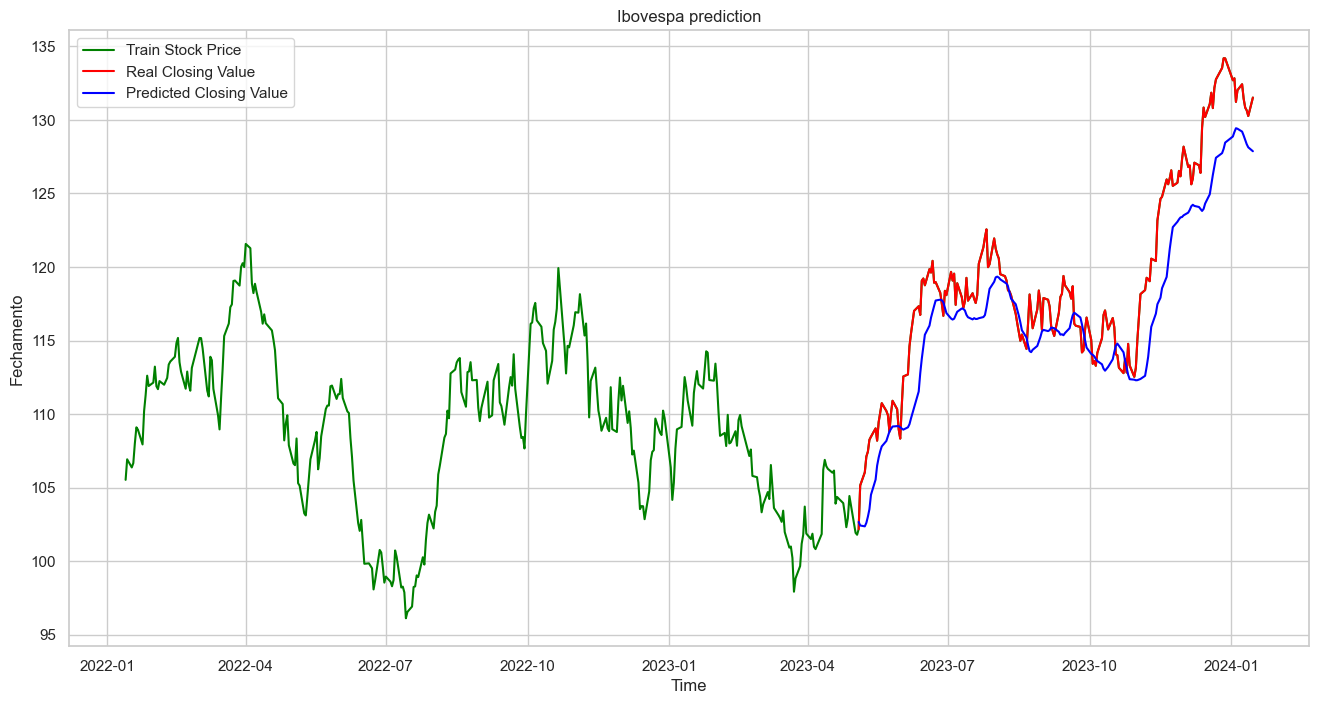

MSE: 10.250465925730447
MAE: 2.6311875575474324
RMSE: 3.201634883263619


In [65]:
from matplotlib            import pyplot as plt
close_up_df = 500

plt.figure(figsize=(16,8))
plt.plot(ibovespa_merged.index[-close_up_df:], ibovespa_merged['Último'].tail(close_up_df), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Closing Value')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Closing Value')
plt.title('Ibovespa prediction')
plt.xlabel('Time')
plt.ylabel('Fechamento')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

In [66]:
# Inicializando as variáveis
size = len(ibovespa_merged)
array_last_7_days = ibovespa_merged['Último'][size - 7: size].values
array_last_7_days = array_last_7_days.reshape(-1,1)
array_last_7_days = scaler.transform(array_last_7_days)

# Definindo o intervalo de datas para as previsões
start_date = '2024-01-15'
end_date = '2024-01-19'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Inicializando a lista para armazenar as previsões
predictions = []

# Loop para gerar previsões para cada data no intervalo
for current_date in date_range:
    # Fazendo a previsão para o próximo dia
    future_predict = model.predict(np.array([array_last_7_days]))
    future_predict = scaler.inverse_transform(future_predict)

    # Atualizando a lista de previsões
    predictions.append(future_predict[0, 0])

    # Transformando o valor previsto de volta para a escala original antes de atualizar a matriz
    future_predict_scaled = scaler.transform(future_predict)


    # Preparando os dados dos últimos 7 dias para a próxima iteração
    array_last_7_days = np.append(array_last_7_days[1:], future_predict_scaled).reshape(-1, 1)

# Convertendo as previsões para um DataFrame para facilitar a visualização e análise
forecast = pd.DataFrame(data={'Date': date_range, 'Predicted': predictions})

# Exibindo as previsões
print(forecast)

1/1 [==============================] - 0s 9ms/step
        Date   Predicted
0 2024-01-15  127.742050
1 2024-01-16  127.443451
2 2024-01-17  126.974426
3 2024-01-18  126.443192
4 2024-01-19  125.848495


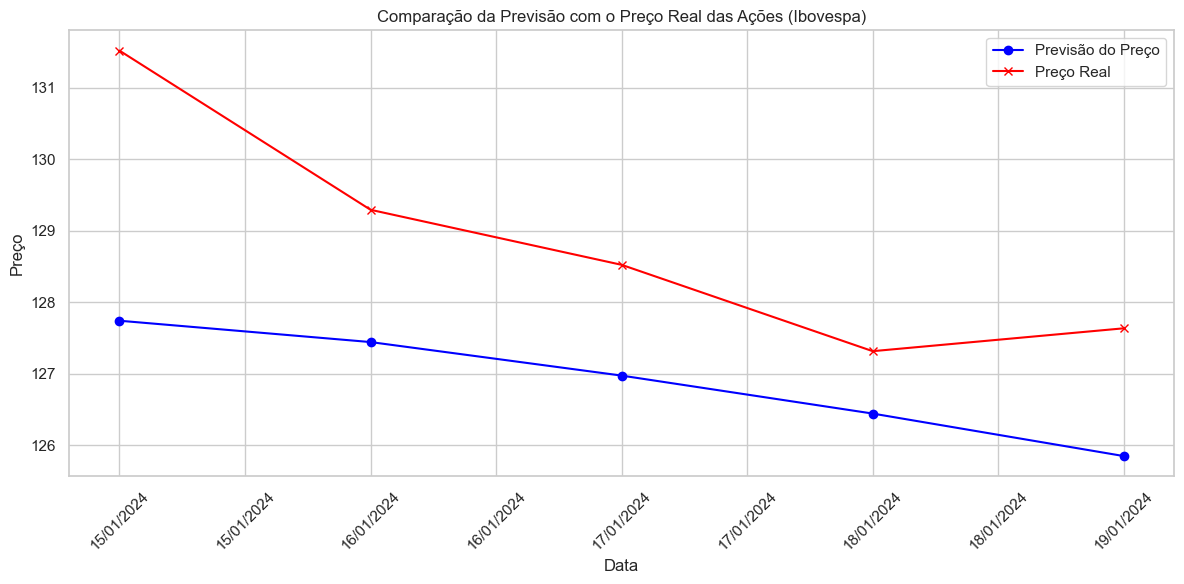

In [67]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Avaliação manual dos datos de fechamento
# Dados dos preços reais das ações
data = {
    'Date': ['2024-01-19', '2024-01-18', '2024-01-17', '2024-01-16', '2024-01-15'],
    'Price': [127.636, 127.316, 128.524, 129.294, 131.521]
}

# Convertendo para DataFrame
actual_prices = pd.DataFrame(data)
actual_prices['Date'] = pd.to_datetime(actual_prices['Date'], format='%Y-%m-%d')
actual_prices.set_index('Date', inplace=True)
actual_prices.sort_index(inplace=True)


# Criando um gráfico para visualizar as previsões e os preços reais
plt.figure(figsize=(12, 6))

# Plotando as previsões
plt.plot(forecast['Date'], forecast['Predicted'], color='blue', marker='o', linestyle='-', label='Previsão do Preço')

# Plotando os preços reais
plt.plot(actual_prices.index, actual_prices['Price'], color='red', marker='x', linestyle='-', label='Preço Real')

# Formatando a legenda do eixo x para datas
# Você pode ajustar o formato da data aqui. '%Y-%m-%d' representa o formato 'Ano-Mês-Dia'.
date_format = mdates.DateFormatter('%d/%m/%Y')
plt.gca().xaxis.set_major_formatter(date_format)

# Adicionando título, rótulos e legenda
plt.title('Comparação da Previsão com o Preço Real das Ações (Ibovespa)')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()

# Ajustando formatação da data
plt.xticks(rotation=45)
# Ajustando o layout
plt.tight_layout()

# Exibindo o gráfico
plt.show()
